In [ ]:
!pip install ipywidgets

In [1]:
import re
import dash
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from googletrans import Translator
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from dash import dcc, html
from dash.dependencies import Input, Output
from plotly.subplots import make_subplots
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
import ipywidgets as widgets
from IPython.display import display
import seaborn as sns
import plotly.graph_objs as go
import plotly.express as px
import plotly.colors as pc
import nltk

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 30)

In [3]:
traduction_colonnes = {
    'customer_id': 'identifiant_client',
    'customer_unique_id': 'identifiant_unique_client',
    'customer_zip_code_prefix': 'code_postal_client',
    'customer_city': 'ville_client',
    'customer_state': 'etat_client',
    'geolocation_zip_code_prefix': 'code_postal_geolocalisation',
    'geolocation_lat': 'latitude_geolocalisation',
    'geolocation_lng': 'longitude_geolocalisation',
    'geolocation_city': 'ville_geolocalisation',
    'geolocation_state': 'etat_geolocalisation',
    'order_id': 'identifiant_commande',
    'order_status': 'statut_commande',
    'order_purchase_timestamp': 'horodatage_achat_commande',
    'order_approved_at': 'date_approbation_commande',
    'order_delivered_carrier_date': 'date_livraison_transporteur_commande',
    'order_delivered_customer_date': 'date_livraison_client_commande',
    'order_estimated_delivery_date': 'date_livraison_estimee_commande',
    'order_item_id': 'identifiant_element_commande',
    'product_id': 'identifiant_produit',
    'seller_id': 'identifiant_vendeur',
    'shipping_limit_date': 'date_limite_expedition',
    'price': 'prix',
    'freight_value': 'frais_port',
    'payment_sequential': 'sequence_paiement',
    'payment_type': 'type_paiement',
    'payment_installments': 'versements_paiement',
    'payment_value': 'valeur_paiement',
    'review_id': 'identifiant_evaluation',
    'review_score': 'score_evaluation',
    'review_comment_title': 'titre_commentaire_evaluation',
    'review_comment_message': 'message_commentaire_evaluation',
    'review_creation_date': 'date_creation_evaluation',
    'review_answer_timestamp': 'horodatage_reponse_evaluation',
    'product_category_name': 'nom_categorie_produit',
    'product_name_lenght': 'longueur_nom_produit',
    'product_description_lenght': 'longueur_description_produit',
    'product_photos_qty': 'quantite_photos_produit',
    'product_weight_g': 'poids_produit_g',
    'product_length_cm': 'longueur_produit_cm',
    'product_height_cm': 'hauteur_produit_cm',
    'product_width_cm': 'largeur_produit_cm',
    'seller_zip_code_prefix': 'code_postal_vendeur',
    'seller_city': 'ville_vendeur',
    'seller_state': 'etat_vendeur',
    'product_category_name_english': 'nom_categorie_produit_anglais'
}

## 1. Analyse Répartition Géographique des données Démographiques

In [4]:
customers = pd.read_csv("dataset_olist/olist_customers_dataset.csv")
geolocation = pd.read_csv("dataset_olist/olist_geolocation_dataset.csv")
customer_geolocation = pd.merge(customers, geolocation, left_on='customer_zip_code_prefix', right_on='geolocation_zip_code_prefix', how='left')
customer_geolocation = customer_geolocation.loc[:, ~customer_geolocation.columns.duplicated()]
customer_geolocation = customer_geolocation.rename(columns=traduction_colonnes)
del customers
del geolocation

In [5]:
customer_geolocation.replace({np.nan: None}, inplace=True)

In [6]:
customer_geolocation['code_postal_geolocalisation'] = customer_geolocation['code_postal_geolocalisation'].astype('Int64')

### Digramme volume de clients par ville

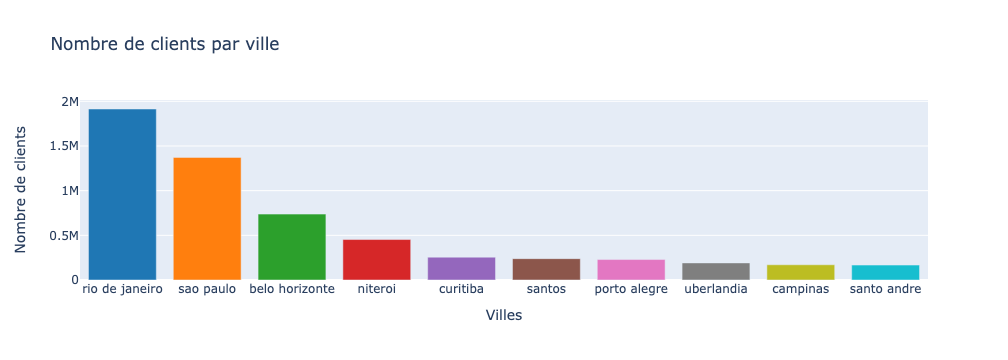

In [9]:
## Compter le nombre de clients pour chaque ville
city_counts = customer_geolocation['ville_client'].value_counts()

# Trier les villes par ordre décroissant du nombre de clients
city_counts = city_counts.sort_values(ascending=False).head(10)

# Extraire les noms des villes et les nombres de clients
cities = city_counts.index
num_clients = city_counts.values

# Créer une palette de couleurs unique pour chaque ville
colors = pc.DEFAULT_PLOTLY_COLORS[:len(cities)]

# Créer une trace de barres avec Plotly
trace = go.Bar(
    x=cities,
    y=num_clients,
    marker=dict(color=colors)  # Couleur des barres pour chaque ville
)

# Créer la mise en page de la figure
layout = go.Layout(
    title='Nombre de clients par ville',
    xaxis=dict(title='Villes'),
    yaxis=dict(title='Nombre de clients')
)

# Créer la figure
fig_client_ville_diag = go.Figure(data=[trace], layout=layout)

# Afficher la figure interactive
fig_client_ville_diag.show()

### Carte Répartition Volume Clients

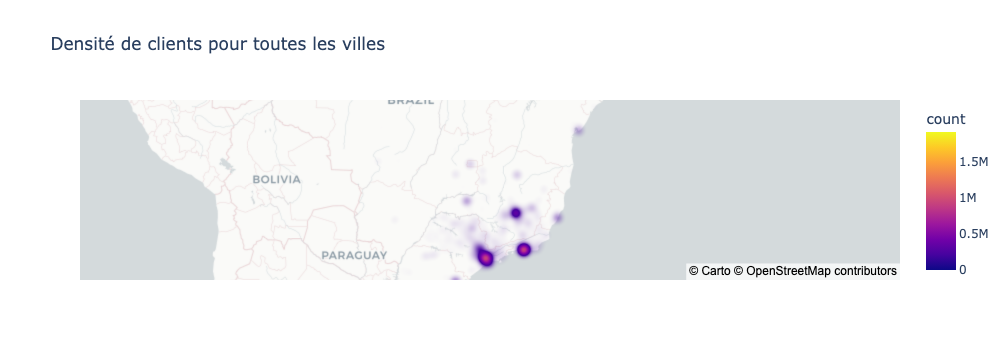

In [10]:
# Compter le nombre de clients pour chaque ville
city_counts = customer_geolocation['ville_client'].value_counts()

# Obtenir la latitude et la longitude moyennes pour chaque ville
city_coords = customer_geolocation.groupby('ville_client')[['latitude_geolocalisation', 'longitude_geolocalisation']].mean()

# Joindre le nombre de clients et les coordonnées pour chaque ville
city_data = city_coords.join(city_counts)

# Créer une carte de chaleur avec Plotly Express
fig_client_ville_carte = px.density_mapbox(city_data, lat='latitude_geolocalisation', lon='longitude_geolocalisation', z='count',
                        radius=10, center=dict(lat=city_data['latitude_geolocalisation'].mean(), 
                                              lon=city_data['longitude_geolocalisation'].mean()),
                        zoom=3, mapbox_style='carto-positron', 
                        title='Densité de clients pour toutes les villes')
# Afficher la carte interactive
fig_client_ville_carte.show()

## 2. Comportement d'achat (order_purchase_timestamp, payment_value) :

In [11]:
payments = pd.read_csv("dataset_olist/olist_order_payments_dataset.csv")
orders = pd.read_csv("dataset_olist/olist_orders_dataset.csv")
payments_orders = pd.merge(payments, orders, on='order_id', how='left')
payments_orders = payments_orders.loc[:, ~payments_orders.columns.duplicated()]
payments_orders = payments_orders.rename(columns=traduction_colonnes)

del orders

In [12]:
# Convertir la colonne 'order_purchase_timestamp' en datetime
payments_orders['horodatage_achat_commande'] = pd.to_datetime(payments_orders['horodatage_achat_commande'])

In [13]:
# Créer une nouvelle colonne pour représenter la période de la journée
payments_orders['purchase_period'] = payments_orders['horodatage_achat_commande'].dt.hour.apply(lambda x: 
                    'Matin' if 6 <= x < 12 
                    else 'Après-midi' if 12 <= x < 18 
                    else 'Soirée' if 18 <= x < 24 
                    else 'Nuit')

In [14]:
# Grouper les données par période de la journée et calculer le montant total des paiements
purchase_period_totals = payments_orders.groupby('purchase_period')['valeur_paiement'].sum().sort_values(ascending=False)

### Diagramme Répartition Achats par période de la journée

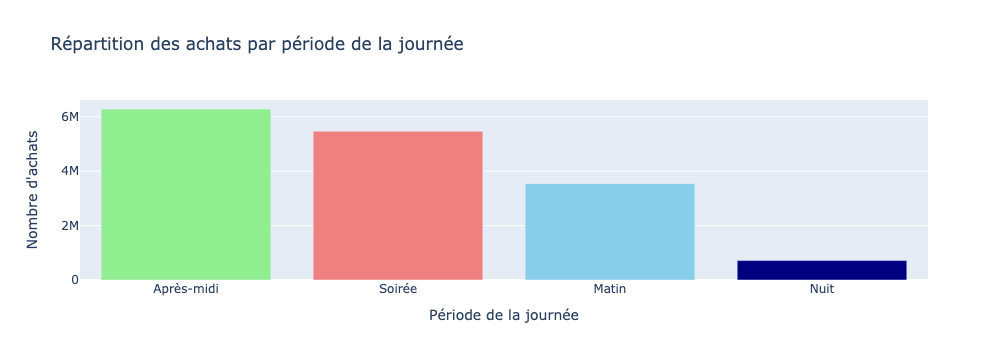

In [18]:
periods = purchase_period_totals.index.tolist()

layout2 = go.Layout(
    title='Répartition des achats par période de la journée',
    xaxis=dict(title='Période de la journée'),
    yaxis=dict(title='Nombre d\'achats')
)

# Définir les couleurs pour chaque période de la journée
colors = {
    'Matin': 'skyblue',
    'Après-midi': 'lightgreen',
    'Soirée': 'lightcoral',
    'Nuit': 'navy'
}

# Créer une trace de barres avec Plotly
bar_trace = go.Bar(
    x=purchase_period_totals.index,
    y=purchase_period_totals.values,
    marker=dict(color=[colors[period] for period in purchase_period_totals.index])
)

# Créer la figure avec la trace de barres et la mise en page
fig_achat_periode_journee = go.Figure(data=[bar_trace], layout=layout2)

# Afficher la figure interactive
fig_achat_periode_journee.show()

## 4. Etude Correlation (Score - Longueur Commentaire) & (Score - Période d'Achat)

In [19]:
order_reviews = pd.read_csv("dataset_olist/olist_order_reviews_dataset.csv")
order_reviews = order_reviews.rename(columns=traduction_colonnes)
order_reviews2 = pd.merge(payments_orders, order_reviews, on='identifiant_commande', how='left')
order_reviews2 = order_reviews2.loc[:, ~order_reviews2.columns.duplicated()]
del order_reviews

### Distribution des scores

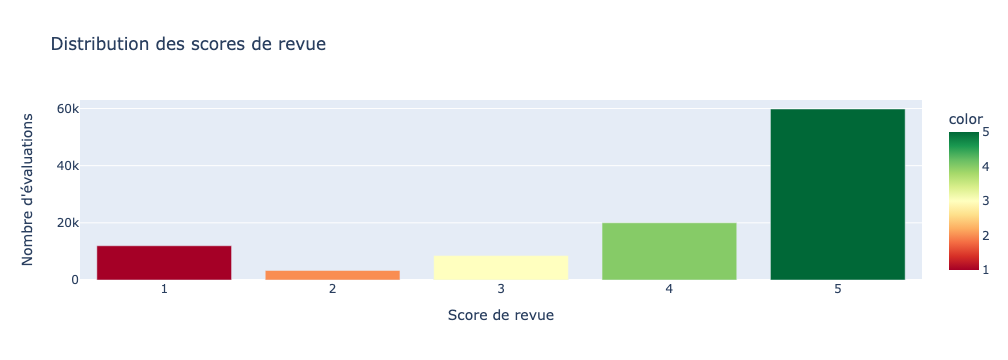

In [21]:
# Calculer le nombre d'évaluations pour chaque score de revue
score_counts = order_reviews2['score_evaluation'].value_counts().sort_index()

# Créer une figure avec Plotly Express
fig_scores = px.bar(x=score_counts.index, y=score_counts.values,
             labels={'x': 'Score de revue', 'y': "Nombre d'évaluations"},
             title='Distribution des scores de revue',
             color=score_counts.index,
             color_continuous_scale='RdYlGn')

# Afficher la figure
fig_scores.show()

In [22]:
# Calculer la longueur des commentaires
order_reviews2['comment_length'] = order_reviews2['message_commentaire_evaluation'].str.len()

### Corrélation Score & longueur commentaire

In [23]:
# Corrélation entre le score de revue et la longueur du commentaire
correlation_length = order_reviews2['score_evaluation'].corr(order_reviews2['comment_length'])
print("Corrélation entre le score de revue et la longueur du commentaire:", correlation_length)
print("Lorsque la longueur du commentaire augmente, le score de la revue a tendance à diminuer, et vice versa.")

Corrélation entre le score de revue et la longueur du commentaire: -0.3761363779164486
Lorsque la longueur du commentaire augmente, le score de la revue a tendance à diminuer, et vice versa.


### Corrélation score et période d'achat

In [24]:
# Mapper les valeurs de la colonne 'purchase_period' à des nombres
period_mapping = {'Matin': 1, 'Après-midi': 2, 'Soirée': 3}
order_reviews2['purchase_period_numeric'] = order_reviews2['purchase_period'].map(period_mapping)

# Calculer la corrélation entre le score de revue et la période d'achat
correlation_period = order_reviews2['score_evaluation'].corr(order_reviews2['purchase_period_numeric'])

print("Corrélation entre le score de revue et la période d'achat:", correlation_period)
print("Il n'y a presque pas de relation entre la période d'achat et le score.")

Corrélation entre le score de revue et la période d'achat: -0.0025853280497095945
Il n'y a presque pas de relation entre la période d'achat et le score.


## 5. Chiffre d'affaires par géolocalisation

In [26]:
order_geolocation = pd.merge(order_reviews2, customer_geolocation, on='identifiant_client', how='left')

In [ ]:
order_geolocation.columns

In [27]:
# Regroupement des données par zone géographique
revenue_by_location = order_geolocation.groupby(['ville_geolocalisation', 'etat_geolocalisation'])['valeur_paiement'].sum()

In [28]:
# Trier les zones géographiques par chiffre d'affaires décroissant
revenue_by_location = revenue_by_location.sort_values(ascending=False)

In [29]:
# Afficher les zones géographiques avec le plus de chiffre d'affaires
top_locations = revenue_by_location.head(10)
print("Zones géographiques avec le plus de chiffre d'affaires :\n", top_locations)

Zones géographiques avec le plus de chiffre d'affaires :
 ville_geolocalisation  etat_geolocalisation
rio de janeiro         RJ                      3.274894e+08
sao paulo              SP                      1.677953e+08
belo horizonte         MG                      1.146364e+08
niteroi                RJ                      6.637833e+07
curitiba               PR                      4.088588e+07
porto alegre           RS                      3.746860e+07
santos                 SP                      3.738064e+07
salvador               BA                      3.129640e+07
são paulo              SP                      3.013852e+07
campinas               SP                      2.557878e+07
Name: valeur_paiement, dtype: float64


### CA par ville

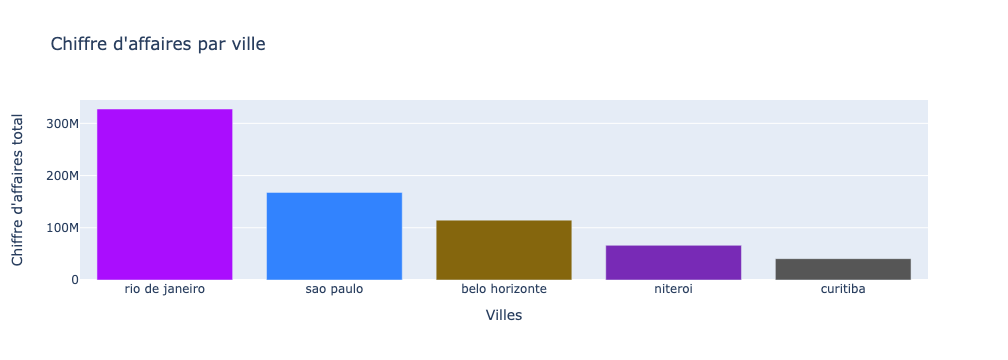

In [31]:
# Calculer le chiffre d'affaires total pour chaque ville et sélectionner les 10 villes avec le plus grand chiffre d'affaires
revenue_by_city = order_geolocation.groupby('ville_geolocalisation')['valeur_paiement'].sum().sort_values(ascending=False).head(5)

# Extraire les noms des villes et les chiffres d'affaires
cities = revenue_by_city.index
total_revenue = revenue_by_city.values

# Créer une palette de couleurs unique pour chaque ville
colors = px.colors.qualitative.Alphabet[:len(cities)]

# Créer une trace de barres avec Plotly
trace = go.Bar(
    x=cities,
    y=total_revenue,
    marker=dict(color=colors)  # Couleur des barres pour chaque ville
)

# Créer la mise en page de la figure
layout = go.Layout(
    title='Chiffre d\'affaires par ville',
    xaxis=dict(title='Villes'),
    yaxis=dict(title='Chiffre d\'affaires total')
)

# Créer la figure
fig_ca_ville = go.Figure(data=[trace], layout=layout)

# Afficher la figure interactive
fig_ca_ville.show()

## 6. Volume de Ventes - CA par catégorie de produit

In [ ]:
order_geolocation.columns

In [32]:
product = pd.read_csv("dataset_olist/olist_products_dataset.csv")
orders1 = pd.read_csv("dataset_olist/olist_order_items_dataset.csv")
product_orders = pd.merge(product, orders1, on='product_id', how='left')

In [33]:
cat = pd.read_csv("dataset_olist/product_category_name_translation.csv")
product_orders2 = pd.merge(product_orders, cat, on='product_category_name', how='left')

In [34]:
product_orders3 = pd.merge(payments, product_orders2, on='order_id', how='left')

In [36]:
product_orders3 = product_orders3.rename(columns=traduction_colonnes)
product_orders3 = product_orders3.loc[:, ~product_orders3.columns.duplicated()]

In [ ]:
product_orders3.head()

In [37]:
del cat, product, orders1, product_orders2

In [ ]:
product_orders3.columns

In [38]:
# Regrouper les données par catégorie de produit et calculer le nombre total d'articles vendus et le chiffre d'affaires total
product_sales = product_orders3.groupby('nom_categorie_produit_anglais').agg({'identifiant_commande': 'count', 'valeur_paiement': 'sum'})

# Renommer les colonnes
product_sales.rename(columns={'identifiant_commande': 'total_articles_sold', 'valeur_paiement': 'total_revenue'}, inplace=True)

# Trier les catégories de produits par volume des ventes et chiffre d'affaires décroissants
product_sales_sorted_by_volume = product_sales.sort_values(by='total_articles_sold', ascending=False)
product_sales_sorted_by_revenue = product_sales.sort_values(by='total_revenue', ascending=False)

# Afficher les catégories de produits les plus vendues en fonction du volume des ventes
print("Catégories de produits les plus vendues par volume des ventes :\n", product_sales_sorted_by_volume.head(10))

# Afficher les catégories de produits les plus vendues en fonction du chiffre d'affaires
print("Catégories de produits les plus vendues par chiffre d'affaires :\n", product_sales_sorted_by_revenue.head(10))

Catégories de produits les plus vendues par volume des ventes :
                                total_articles_sold  total_revenue
nom_categorie_produit_anglais                                    
bed_bath_table                               11823     1712553.67
health_beauty                                 9972     1657373.12
sports_leisure                                8945     1392127.56
furniture_decor                               8744     1430176.39
computers_accessories                         8082     1585330.45
housewares                                    7355     1094758.13
watches_gifts                                 6201     1429216.68
telephony                                     4721      486882.05
garden_tools                                  4574      838280.75
auto                                          4379      852294.33
Catégories de produits les plus vendues par chiffre d'affaires :
                                total_articles_sold  total_revenue
nom_categor

In [39]:
product_sales_sorted_by_volume_graph = product_sales_sorted_by_volume.head(5)
product_sales_sorted_by_revenue_graph = product_sales_sorted_by_revenue.head(5)

### Catégories des produits les plus vendues

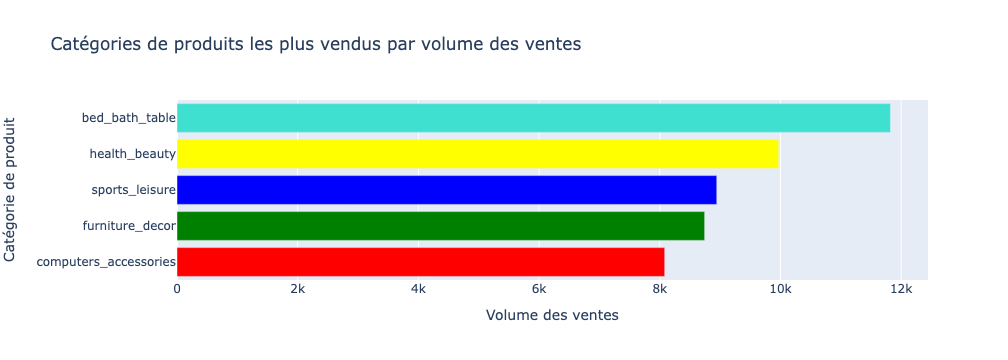

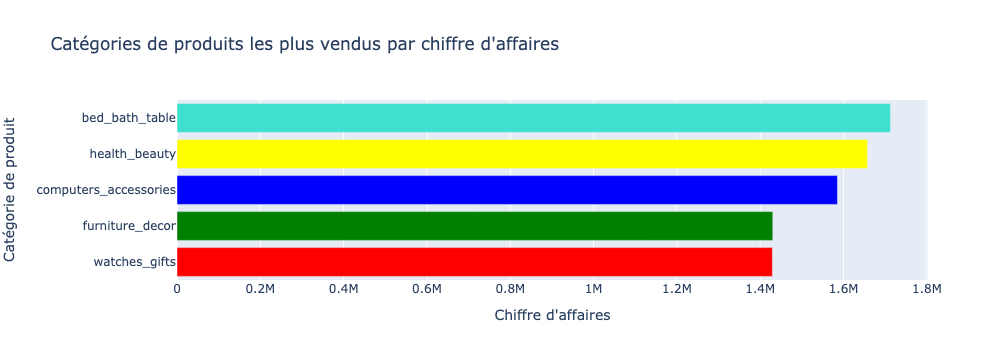

In [42]:
colors = ['red', 'green', 'blue', 'yellow', 'turquoise']

# Créer une figure pour les catégories de produits les plus vendues par volume des ventes
fig_volume_cat = go.Figure(go.Bar(
    y=product_sales_sorted_by_volume_graph.index[::-1],
    x=product_sales_sorted_by_volume_graph['total_articles_sold'][::-1],
    orientation='h',
    name='Volume des ventes',
    marker=dict(color=colors)
))

# Créer une figure pour les catégories de produits les plus vendues par chiffre d'affaires
fig_revenue_cat = go.Figure(go.Bar(
    y=product_sales_sorted_by_revenue_graph.index[::-1],
    x=product_sales_sorted_by_revenue_graph['total_revenue'][::-1],
    orientation='h',
    name='Chiffre d\'affaires',
    marker=dict(color=colors)
))

# Mise en forme de la figure pour les catégories de produits les plus vendues par volume des ventes
fig_volume_cat.update_layout(
    title='Catégories de produits les plus vendus par volume des ventes',
    xaxis=dict(title='Volume des ventes'),
    yaxis=dict(title='Catégorie de produit'),
    barmode='stack'
)

# Mise en forme de la figure pour les catégories de produits les plus vendues par chiffre d'affaires
fig_revenue_cat.update_layout(
    title='Catégories de produits les plus vendus par chiffre d\'affaires',
    xaxis=dict(title='Chiffre d\'affaires'),
    yaxis=dict(title='Catégorie de produit'),
    barmode='stack'
)

# Afficher les figures
fig_volume_cat.show()
fig_revenue_cat.show()

## 7. Analyse du type de Paiement

In [ ]:
order_geolocation.columns

In [43]:
# Regrouper les données par moyen de paiement et calculer différentes caractéristiques
payment_analysis = order_geolocation.groupby('type_paiement').agg({
    'valeur_paiement': ['sum', 'mean'],  # Montant total et moyen des paiements
    'identifiant_commande': 'count',  # Nombre total de paiements
}).reset_index()

# Renommer les colonnes pour une meilleure lisibilité
payment_analysis.columns = ['payment_type', 'total_payment_amount', 'average_payment_amount', 'total_payments']

# Afficher l'analyse des moyens de paiement
print(payment_analysis)

  payment_type  total_payment_amount  average_payment_amount  total_payments
0       boleto          4.358801e+08              146.698295         2971269
1  credit_card          1.932028e+09              164.074295        11775327
2   debit_card          3.333598e+07              146.931554          226881
3  not_defined          0.000000e+00                0.000000             239
4      voucher          5.834278e+07               66.733288          874268


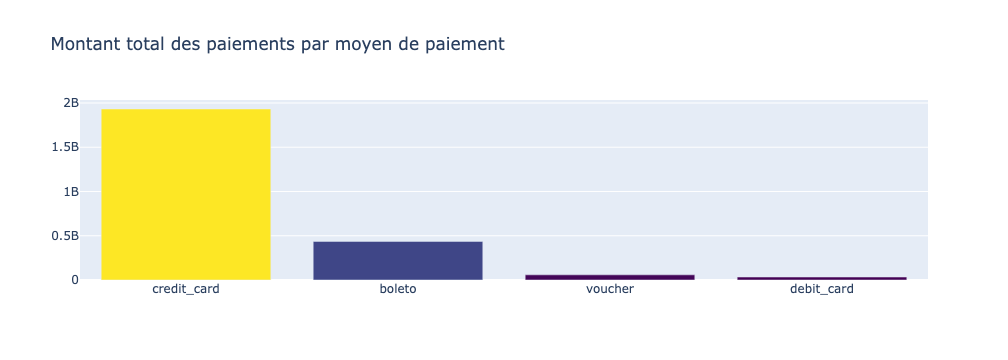

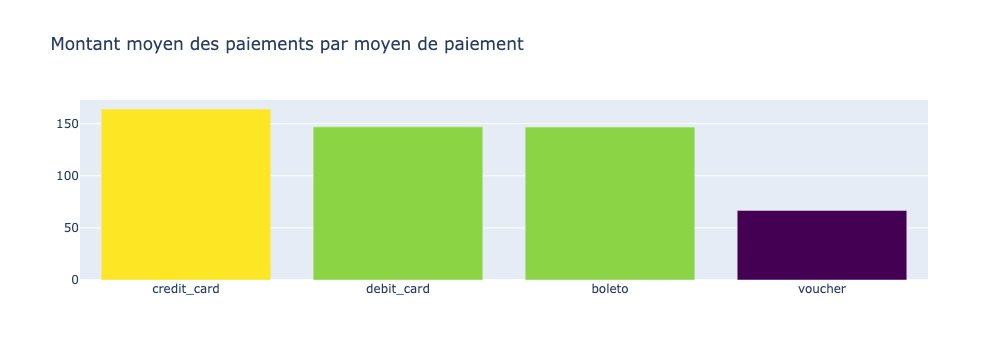

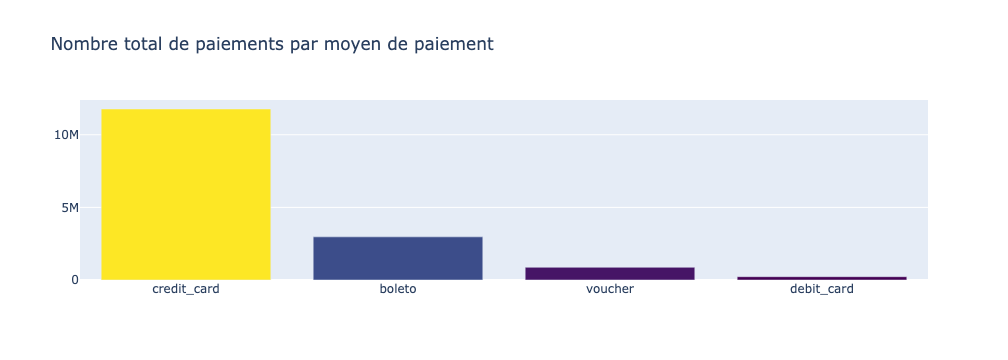

In [44]:
payment_analysis = payment_analysis[payment_analysis['payment_type'] != 'not_defined']

# Trier les moyens de paiement par montant total des paiements, montant moyen des paiements et nombre total de paiements décroissants
payment_analysis_sorted_by_total_amount = payment_analysis.sort_values(by='total_payment_amount', ascending=False)
payment_analysis_sorted_by_average_amount = payment_analysis.sort_values(by='average_payment_amount', ascending=False)
payment_analysis_sorted_by_total_payments = payment_analysis.sort_values(by='total_payments', ascending=False)

# Créer un graphique pour le montant total des paiements
fig_total_amount = go.Figure(go.Bar(
    x=payment_analysis_sorted_by_total_amount['payment_type'],
    y=payment_analysis_sorted_by_total_amount['total_payment_amount'],
    marker=dict(color=payment_analysis_sorted_by_total_amount['total_payment_amount'], colorscale='viridis'),
))
fig_total_amount.update_layout(title='Montant total des paiements par moyen de paiement')

# Créer un graphique pour le montant moyen des paiements
fig_average_amount = go.Figure(go.Bar(
    x=payment_analysis_sorted_by_average_amount['payment_type'],
    y=payment_analysis_sorted_by_average_amount['average_payment_amount'],
    marker=dict(color=payment_analysis_sorted_by_average_amount['average_payment_amount'], colorscale='viridis'),
))
fig_average_amount.update_layout(title='Montant moyen des paiements par moyen de paiement')

# Créer un graphique pour le nombre total de paiements
fig_total_payments = go.Figure(go.Bar(
    x=payment_analysis_sorted_by_total_payments['payment_type'],
    y=payment_analysis_sorted_by_total_payments['total_payments'],
    marker=dict(color=payment_analysis_sorted_by_total_payments['total_payments'], colorscale='viridis'),
))
fig_total_payments.update_layout(title='Nombre total de paiements par moyen de paiement')

# Afficher les graphiques
fig_total_amount.show()
fig_average_amount.show()
fig_total_payments.show()

## 3. Feedback client (review_score, review_comment_message) :

In [ ]:
order_reviews2['message_commentaire_evaluation'].isna().sum()

In [ ]:
df_test = order_reviews2.dropna()
df_test['message_commentaire_evaluation'].count().sum()

In [ ]:
# Créer une instance du traducteur
translator = Translator()

# Fonction pour traduire les commentaires en anglais
def translate_to_english(comment):
    try:
        # Traduire le commentaire en anglais
        translation = translator.translate(comment, src='pt', dest='en')
        return translation.text
    except:
        return comment  # En cas d'erreur, retourner le commentaire d'origine

In [ ]:
# Fonction pour enlever les émoticônes des commentaires
def remove_emojis(text):
    # Définir une expression régulière pour rechercher les émoticônes
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # Emoticons
                               u"\U0001F300-\U0001F5FF"  # Symboles & pictogrammes
                               u"\U0001F680-\U0001F6FF"  # Transport & symboles map
                               u"\U0001F1E0-\U0001F1FF"  # Drapeaux (iOS)
                               u"\U00002500-\U00002BEF"  # Chinois, japonais, coréen (Hangeul, Hiragana, Katakana)
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    # Remplacer les émoticônes par une chaîne vide
    return emoji_pattern.sub(r'', text)

In [ ]:
# Appliquer la fonction pour enlever les émoticônes aux commentaires
df_test['review_comment_message_clean'] = df_test['message_commentaire_evaluation'].apply(remove_emojis)

In [ ]:
# Traduire les commentaires en anglais
df_test['review_comment_message_en'] = df_test['review_comment_message_clean'].apply(translate_to_english)

In [ ]:
df_test['review_comment_message_en'].tail()

In [81]:
analyse_comments = pd.read_csv("dataset_olist/translated_comments.csv")

In [82]:
analyse_comments = analyse_comments.dropna()

In [84]:
analyse_comments.tail()

,identifiant_commande,sequence_paiement,type_paiement,versements_paiement,valeur_paiement,identifiant_client,statut_commande,horodatage_achat_commande,date_approbation_commande,date_livraison_transporteur_commande,date_livraison_client_commande,date_livraison_estimee_commande,purchase_period,identifiant_evaluation,score_evaluation,titre_commentaire_evaluation,message_commentaire_evaluation,date_creation_evaluation,horodatage_reponse_evaluation,comment_length,purchase_period_numeric,review_comment_message_clean,review_comment_message_en,cluster_label
9362,2ab10ab526351fd3b05219e9eb4f7d9f,1,credit_card,8,366.73,5038412e993abfa85f57ec66af30e303,delivered,2018-06-13 22:17:25,2018-06-13 22:40:16,2018-06-14 14:47:00,2018-06-20 17:58:42,2018-07-03 00:00:00,Soirée,e9c949c3e29e6f5f9f952ea98e555bc8,5.0,recomendo,"produto veio antes do prazo, muito bem embalad...",2018-06-21 00:00:00,2018-06-22 23:45:43,75.0,3.0,"produto veio antes do prazo, muito bem embalad...","product came before the deadline, very well pa...",3
9363,31b39339d93a6949e2f2addf798d8904,1,credit_card,1,114.49,e0c699c921f40e59216aec9d5b909f43,delivered,2018-07-29 13:07:11,2018-07-29 13:24:20,2018-07-30 15:36:00,2018-07-31 14:56:30,2018-08-02 00:00:00,Après-midi,6d1f8981d8d9876a392015350e52f1be,5.0,Perfeito!,"Produto de ótima qualidade, bem embalado e ent...",2018-08-01 00:00:00,2018-08-02 11:16:57,66.0,2.0,"Produto de ótima qualidade, bem embalado e ent...","Product of great quality, well packaged and de...",1
9364,93c244c6bb63cafcde3117a2b2a5e151,1,credit_card,10,195.86,0e72af1dbf7a7c521b03af207c03d86d,delivered,2018-05-03 12:32:25,2018-05-03 12:55:01,2018-05-04 13:38:00,2018-05-10 23:54:33,2018-05-22 00:00:00,Après-midi,b47b6464ca08cc70d28fd74b9f7f227d,2.0,Embalagem horrorosa,O produto vendido pela targaryen chegou em uma...,2018-05-11 00:00:00,2018-05-14 14:08:38,199.0,2.0,O produto vendido pela targaryen chegou em uma...,The product sold by Targaryen arrived in a car...,2
9365,38d11c87fc409de31e930084abb0c7a4,1,credit_card,7,91.03,3cb70d43ff082f7257213b7b055bf35a,delivered,2018-08-17 17:38:51,2018-08-17 17:50:15,2018-08-20 15:29:00,2018-08-24 17:56:31,2018-09-03 00:00:00,Après-midi,d6050b36487220bdaccd334bb5ef4743,5.0,MUITO BOA AMERICANA,Ótima rápida na entrega OBRIGADO,2018-08-25 00:00:00,2018-08-25 22:07:39,33.0,2.0,Ótima rápida na entrega OBRIGADO,Great quick delivery thanks,1
9366,60aed0a4eba0e424eb3cac85017fd752,1,credit_card,10,170.14,c596bc25904f9043dae514f6a26c89d3,delivered,2018-06-18 13:07:05,2018-06-18 13:39:36,2018-06-19 14:30:00,2018-06-22 23:08:29,2018-07-19 00:00:00,Après-midi,03d3ae62cbb656b7e3c2286866217647,5.0,5,"super indico , pois o produto chegou em perfei...",2018-06-23 00:00:00,2018-07-05 16:34:05,112.0,2.0,"super indico , pois o produto chegou em perfei...","Super indicate, because the product arrived in...",0


In [86]:
# Vectorisation des commentaires
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(analyse_comments['review_comment_message_en'].values.astype('U'))

# Appliquer le clustering de texte
kmeans = KMeans(n_clusters=5, random_state=42)
labels = kmeans.fit_predict(tfidf_matrix)

# Afficher les clusters obtenus
print(labels)
analyse_comments['cluster_label'] = labels

[3 3 3 ... 3 0 0]


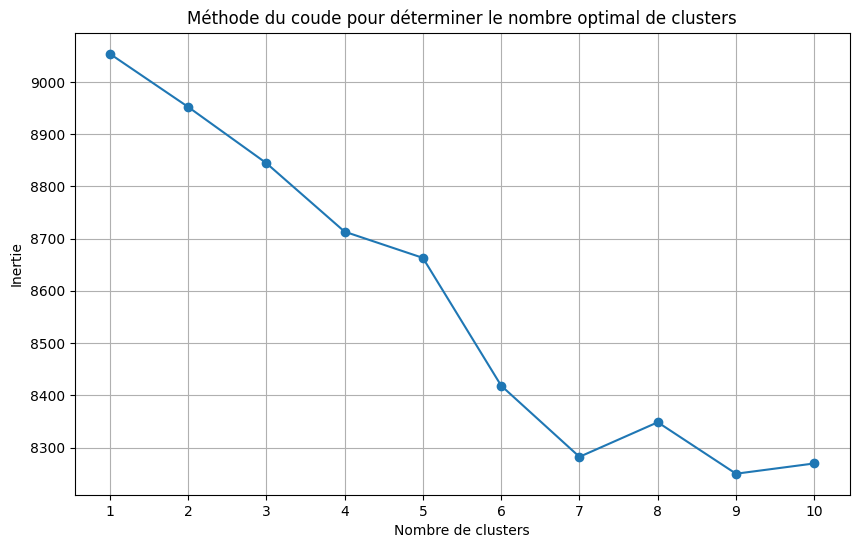

In [87]:
# Liste pour stocker l'inertie
inertia = []

# Nombre de clusters à tester
k_range = range(1, 11)

# Calcul de l'inertie pour chaque nombre de clusters
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(tfidf_matrix)
    inertia.append(kmeans.inertia_)

# Tracer le graphique de l'inertie en fonction du nombre de clusters
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='-')
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude pour déterminer le nombre optimal de clusters')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [88]:
# Séparation des commentaires par cluster
cluster_comments = {}
for cluster_id in range(k):
    cluster_comments[cluster_id] = analyse_comments[analyse_comments['cluster_label'] == cluster_id]['review_comment_message_en'].tolist()

In [89]:
def preprocess_comments(comments):
    if isinstance(comments, str):

        # Conversion en minuscules
        comments = [comment.lower() for comment in comments]
    
        # Suppression des caractères spéciaux et des chiffres
        comments = [re.sub(r'[^a-zA-Z\s]', '', comment) for comment in comments]
        
        # Tokenization des commentaires
        comments = [word_tokenize(comment) for comment in comments]
        
        # Suppression des stopwords
        stop_words = set(stopwords.words('english'))
        comments = [[word for word in comment if word not in stop_words] for comment in comments]
        
        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        comments = [[lemmatizer.lemmatize(word) for word in comment] for comment in comments]
        
        # Fusion des tokens en phrases
        comments = [' '.join(comment) for comment in comments]
    
    return comments

In [ ]:
nltk.download('punkt')

In [ ]:
nltk.download('stopwords')

In [ ]:
nltk.download('wordnet')

In [90]:
# Prétraitement des commentaires
preprocessed_comments = {}
for cluster_id, comments in cluster_comments.items():
    preprocessed_comments[cluster_id] = preprocess_comments(comments)



Cluster 0: Mots clés les plus fréquents - [('the', 987), ('product', 600), ('before', 498), ('and', 493), ('arrived', 443), ('I', 384), ('delivery', 338), ('Great', 239), ('fast', 232), ('very', 197)]




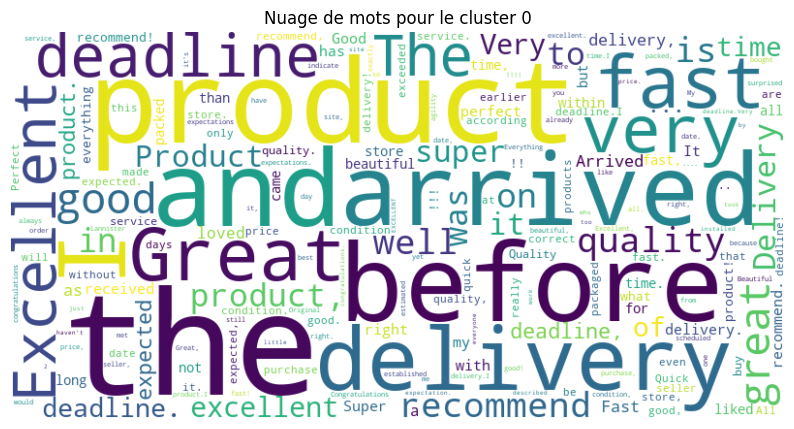



Cluster 1: Mots clés les plus fréquents - [('delivered', 445), ('the', 445), ('before', 218), ('and', 209), ('was', 174), ('product', 160), ('Product', 153), ('I', 131), ('on', 125), ('deadline', 84)]




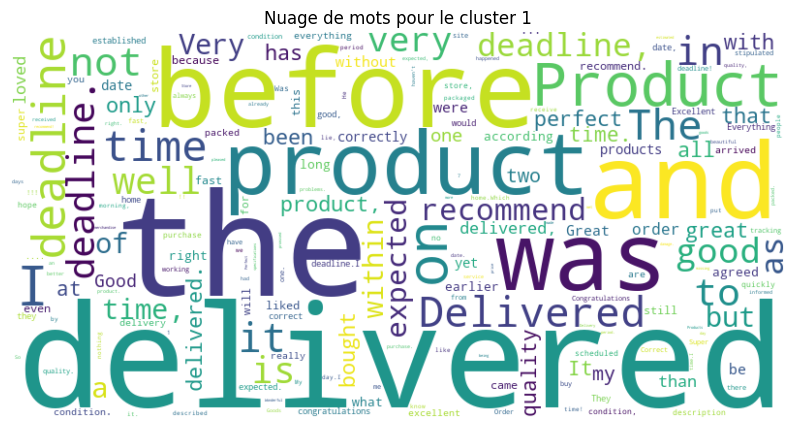



Cluster 2: Mots clés les plus fréquents - [('o', 531), ('e', 528), ('do', 470), ('produto', 437), ('a', 375), ('de', 351), ('que', 289), ('muito', 275), ('não', 270), ('antes', 265)]




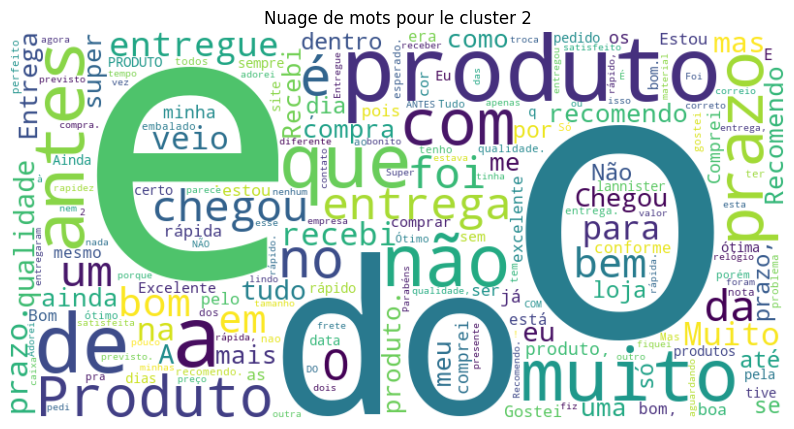



Cluster 3: Mots clés les plus fréquents - [('the', 5238), ('I', 3588), ('and', 2052), ('to', 1434), ('product', 1295), ('not', 1144), ('is', 1104), ('a', 1051), ('it', 978), ('of', 935)]




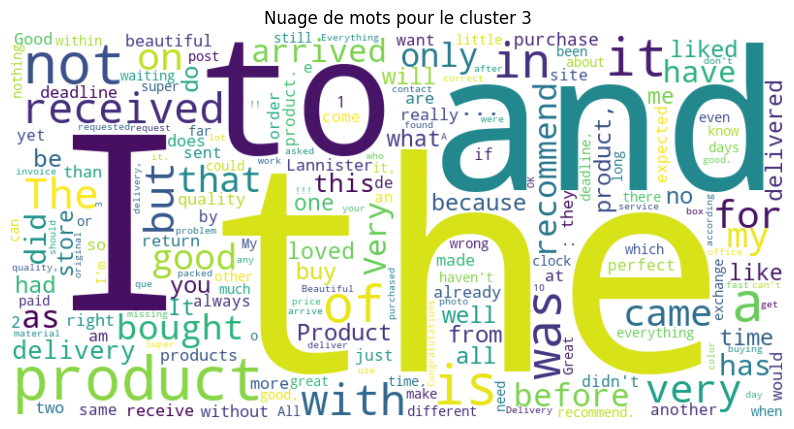



Cluster 4: Mots clés les plus fréquents - [('the', 80), ('satisfied', 66), ('I', 57), ('and', 34), ('with', 33), ('am', 32), ('product', 30), ('very', 26), ('before', 25), ('Very', 22)]




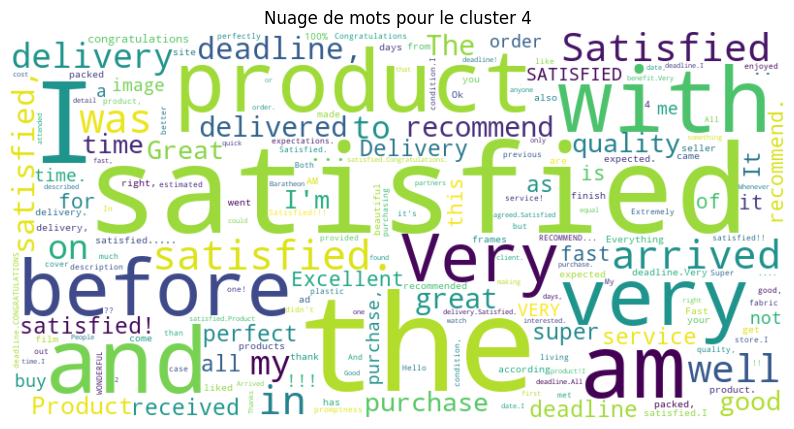



Cluster 5: Mots clés les plus fréquents - []




ValueError: We need at least 1 word to plot a word cloud, got 0.

In [91]:
# Analyse des mots clés fréquents
for cluster_id, comments in cluster_comments.items():
    valid_comments = [comment for comment in comments if isinstance(comment, str)]  # Filtrer les commentaires valides
    word_freq = Counter([word for comment in valid_comments for word in comment.split()])
    print("\n")
    print(f"Cluster {cluster_id}: Mots clés les plus fréquents - {word_freq.most_common(10)}")
    print("\n")
    # Visualisation des mots clés avec un nuage de mots
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(word_freq))
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Nuage de mots pour le cluster {cluster_id}")
    plt.axis('off')
    plt.show()

In [92]:
# Calcul de la longueur moyenne des commentaires
for cluster_id, comments in preprocessed_comments.items():
    avg_comment_length = sum(len(comment.split()) for comment in comments) / len(comments)
    print(f"Cluster {cluster_id}: Longueur moyenne des commentaires - {avg_comment_length}")

Cluster 0: Longueur moyenne des commentaires - 7.659365994236311
Cluster 1: Longueur moyenne des commentaires - 10.114814814814816
Cluster 2: Longueur moyenne des commentaires - 12.552821997105644
Cluster 3: Longueur moyenne des commentaires - 13.209364908503767
Cluster 4: Longueur moyenne des commentaires - 7.877862595419847


ZeroDivisionError: division by zero

In [93]:
# Fonction pour analyser le sentiment d'un commentaire
def analyze_sentiment(comment):
    analysis = TextBlob(comment)
    if analysis.sentiment.polarity > 0:
        return 'positif'
    elif analysis.sentiment.polarity < 0:
        return 'négatif'
    else:
        return 'neutre'

In [94]:
# Appliquer l'analyse des sentiments à chaque commentaire dans chaque cluster
sentiment_results = {}
for cluster_id, comments in preprocessed_comments.items():
    sentiments = [analyze_sentiment(comment) for comment in comments]
    sentiment_results[cluster_id] = sentiments

In [95]:
# Calculer les statistiques sur les sentiments pour chaque cluster
sentiment_statistics = {}
for cluster_id, sentiments in sentiment_results.items():
    sentiment_statistics[cluster_id] = {
        'positif': sentiments.count('positif'),
        'négatif': sentiments.count('négatif'),
        'neutre': sentiments.count('neutre'),
        'total': len(sentiments)
    }

### Diagramme Analyse Sentiments

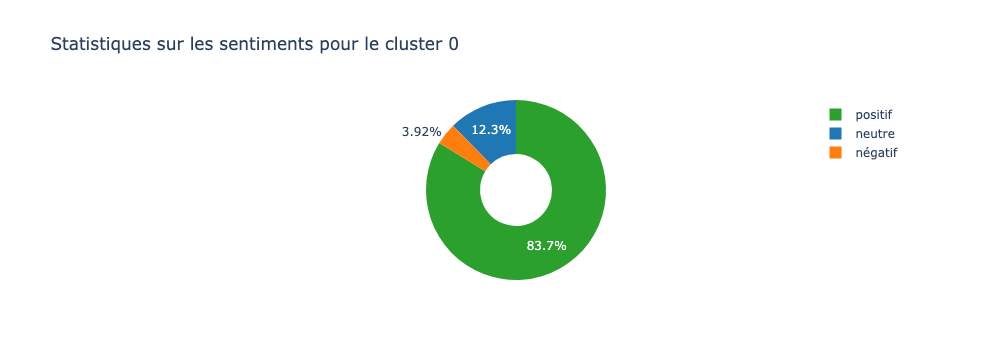

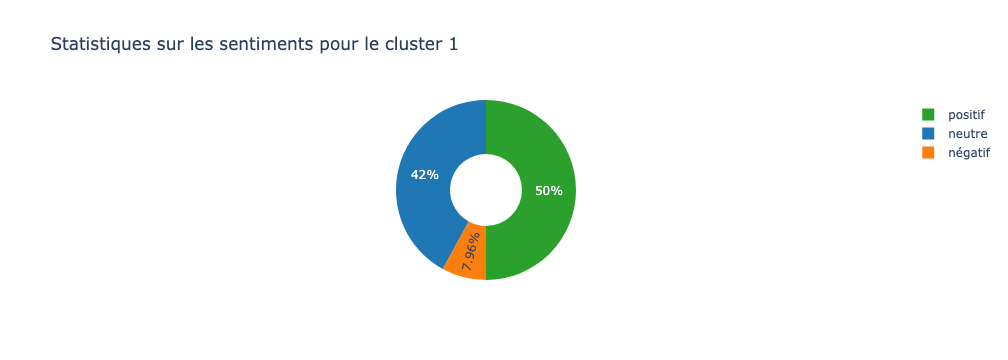

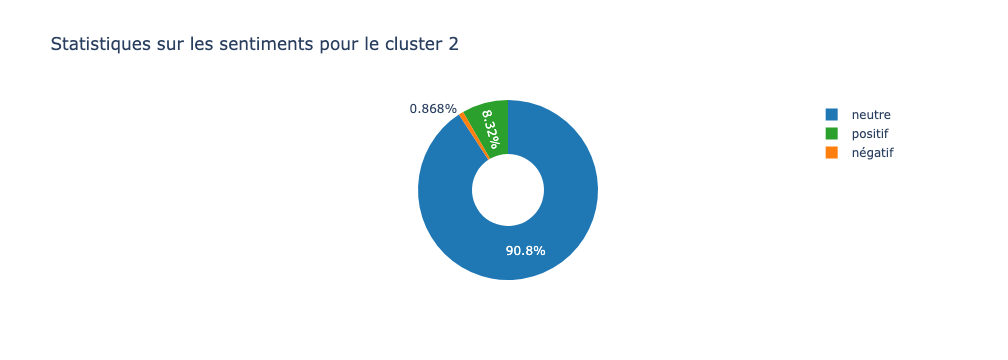

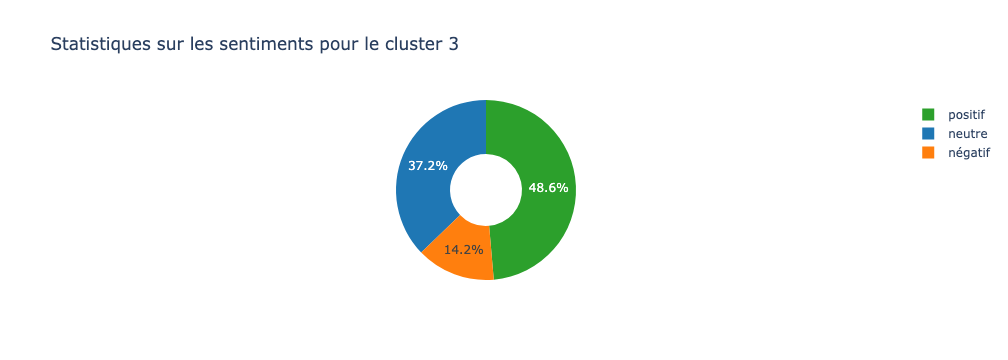

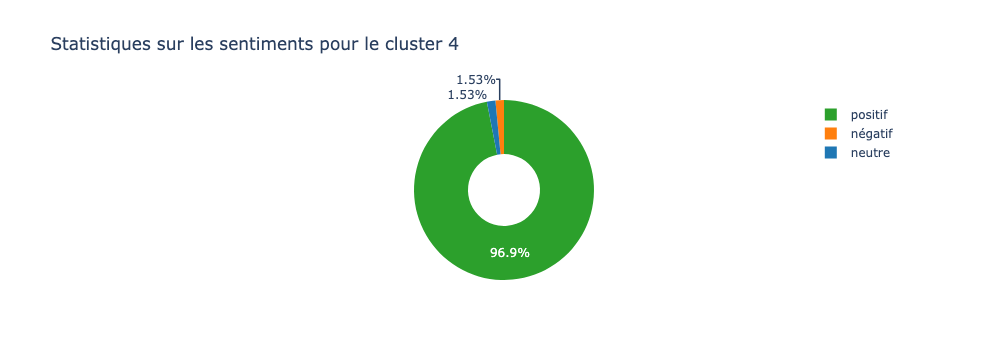

In [96]:
# Fonction pour créer un diagramme circulaire interactif pour les statistiques sur les sentiments
def plot_sentiment_pie_chart_plotly(sentiment_statistics, num_clusters=5):
    colors = ['rgb(44, 160, 44)', 'rgb(255, 127, 14)', 'rgb(31, 119, 180)']  # Trois couleurs fixes représentatives
    
    for cluster_id in range(0, num_clusters):
        stats = sentiment_statistics.get(cluster_id, {'positif': 0, 'négatif': 0, 'neutre': 0})
        labels = ['positif', 'négatif', 'neutre']
        sizes = [stats['positif'], stats['négatif'], stats['neutre']]
        
        fig = go.Figure(data=[go.Pie(
            labels=labels,
            values=sizes,
            hole=0.4,  # Taille du trou au centre du diagramme circulaire
            marker=dict(colors=colors)  # Utiliser les couleurs définies
        )])

        fig.update_layout(
            title=f'Statistiques sur les sentiments pour le cluster {cluster_id}',
        )

        fig.show()

# Afficher les statistiques sur les sentiments pour les 5 premiers clusters avec un diagramme circulaire interactif
plot_sentiment_pie_chart_plotly(sentiment_statistics, num_clusters=5)